In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm



In [11]:
# Set directories for training and test datasets
train_dir = '/Users/tishyakasliwal/Real_AI_SD_LD_Dataset/train/'  
test_dir = '/Users/tishyakasliwal/Real_AI_SD_LD_Dataset/test'    

In [12]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),  # Changed to 64x64
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),  # Changed to 64x64
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [13]:
# Load datasets
train_dataset = ImageFolder(train_dir, transform=train_transforms)
test_dataset = ImageFolder(test_dir, transform=test_transforms)

In [30]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)  # Increased batch size
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)   # Increased batch size

In [3]:
# Define the CNN architecture
class ArtStyleCNN(nn.Module):
    def __init__(self, num_classes=30):
        super(ArtStyleCNN, self).__init__()
        
        # Feature extraction layers
        self.features = nn.Sequential(
            # First block: 64x64 -> 32x32
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Second block: 32x32 -> 16x16
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Third block: 16x16 -> 8x8
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Fourth block: 8x8 -> 4x4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Classification layers
        self.classifier = nn.Sequential(
            nn.Flatten(),  # 256 * 4 * 4 = 4096
            nn.Linear(4096, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [5]:
# Instantiate your model
model = ArtStyleCNN()

# Load the state dictionary into your model
model.load_state_dict(torch.load('final_art_style_cnn.pth'))

# Set the model to evaluation mode if you are using it for inference
model.eval()

/var/folders/2z/ssqbf1vd32x1pypcmcgd5k5m0000gn/T/ipykernel_34273/563390526.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('final_art_st

ArtStyleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): BatchNorm2d(2

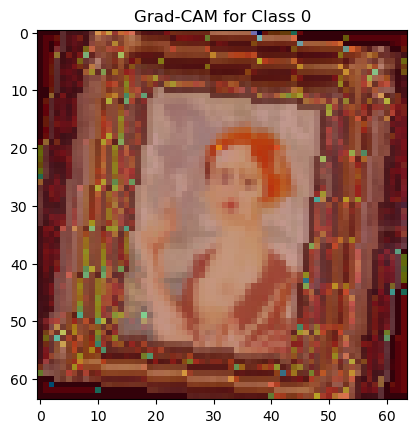

In [27]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

def grad_cam(model, input_image, target_class, target_layer):
    model.eval()
    
    # Forward pass
    activation = None
    gradients = None

    def save_activation(module, input, output):
        nonlocal activation
        activation = output.detach()

    def save_gradient(module, grad_input, grad_output):
        nonlocal gradients
        gradients = grad_output[0].detach()

    # Register hooks
    target_layer.register_forward_hook(save_activation)
    target_layer.register_backward_hook(save_gradient)
    
    # Forward and backward pass
    input_image = input_image.unsqueeze(0)  # Add batch dimension
    output = model(input_image)
    model.zero_grad()
    class_loss = output[0, target_class]
    class_loss.backward()
    
    # Grad-CAM calculations
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    for i in range(activation.shape[1]):
        activation[:, i, :, :] *= pooled_gradients[i]
    
    heatmap = torch.mean(activation, dim=1).squeeze().cpu().numpy()
    heatmap = np.maximum(heatmap, 0)  # ReLU
    heatmap /= np.max(heatmap)  # Normalize
    
    # Convert heatmap to original image size
    heatmap = cv2.resize(heatmap, (input_image.shape[2], input_image.shape[3]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Overlay heatmap on original image
    img = input_image.squeeze().permute(1, 2, 0).cpu().numpy()
    img = img - img.min()
    img = img / img.max()
    img = np.uint8(255 * img)
    overlay = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    
    plt.imshow(overlay)
    plt.title(f"Grad-CAM for Class {target_class}")
    plt.show()

input_image, _ = train_dataset[0]  # Example image
grad_cam(model, input_image, target_class=0, target_layer=model.features[0])


In [28]:
pip install torchcam


  Obtaining dependency information for torchcam from https://files.pythonhosted.org/packages/9a/35/4709f53016e22be6843022991feaf73bab2f41ea96800a4f9a830af6011d/torchcam-0.4.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 939.9 kB/s eta 0:00:000:00:01
Note: you may need to restart the kernel to use updated packages.


In [29]:
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image

In [34]:
# Initialize Grad-CAM
cam_extractor = GradCAM(model, target_layer='features.6')  # Example layer, change as needed

# Test a single batch for Grad-CAM visualization
# inputs, labels = next(iter(test_loader))
inputs, labels = test_dataset[0]
inputs, labels = inputs, labels
outputs = model(inputs)
predicted_classes = outputs.argmax(dim=1)

# Generate Grad-CAM heatmaps
activation_maps = cam_extractor(class_idx=predicted_classes[0].item(), scores=outputs)

# Visualize Grad-CAM heatmap
for i in range(len(inputs)):
    # Convert the image to PIL format for visualization
    img = to_pil_image(inputs[i].cpu())
    heatmap = activation_maps[i].squeeze().cpu()

    # Overlay heatmap on the original image
    result = overlay_mask(img, heatmap, alpha=0.5)
    
    # Display the image with Grad-CAM heatmap
    plt.imshow(result)
    plt.title(f'Predicted Class: {predicted_classes[i].item()}')
    plt.axis('off')
    plt.show()

/Users/tishyakasliwal/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


ValueError: expected 4D input (got 3D input)